In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from torch.nn import Parameter
import matplotlib
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import pyro.ops.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from sklearn import model_selection, datasets
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
"""import GPy
from GPy import kern
from GPy.models import GPLVM"""
from sklearn.linear_model import SGDClassifier
%matplotlib inline
from matplotlib.lines import Line2D
sizeTitle = 24
sizeAxis = 14
smoke_test = ('CI' in os.environ)  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.6.0')
pyro.set_rng_seed(1)

In [2]:
# license: Copyright (c) 2014, the Open Data Science Initiative
URL = "https://raw.githubusercontent.com/sods/ods/master/datasets/guo_qpcr.csv"

df = pd.read_csv(URL, index_col=0)
print("Data shape: {}\n{}\n".format(df.shape, "-" * 21))
print("Data labels: {}\n{}\n".format(df.index.unique().tolist(), "-" * 86))
print("Show a small subset of the data:")
df.head()

Data shape: (437, 48)
---------------------

Data labels: ['1', '2', '4', '8', '16', '32 TE', '32 ICM', '64 PE', '64 TE', '64 EPI']
--------------------------------------------------------------------------------------

Show a small subset of the data:


,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa,Dab2,DppaI,...,Sox2,Sall4,Sox17,Snail,Sox13,Tcfap2a,Tcfap2c,Tcf23,Utf1,Tspan8
1,0.541050,-1.203007,1.030746,1.064808,0.494782,-0.167143,-1.369092,1.083061,0.668057,-1.553758,...,-1.351757,-1.793476,0.783185,-1.408063,-0.031991,-0.351257,-1.078982,0.942981,1.348892,-1.051999
1,0.680832,-1.355306,2.456375,1.234350,0.645494,1.003868,-1.207595,1.208023,0.800388,-1.435306,...,-1.363533,-1.782172,1.532477,-1.361172,-0.501715,1.082362,-0.930112,1.064399,1.469397,-0.996275
1,1.056038,-1.280447,2.046133,1.439795,0.828121,0.983404,-1.460032,1.359447,0.530701,-1.340283,...,-1.296802,-1.567402,3.194157,-1.301777,-0.445219,0.031284,-1.005767,1.211529,1.615421,-0.651393
1,0.732331,-1.326911,2.464234,1.244323,0.654359,0.947023,-1.265609,1.215373,0.765212,-1.431401,...,-1.684100,-1.915556,2.962515,-1.349710,1.875957,1.699892,-1.059458,1.071541,1.476485,-0.699586
1,0.629333,-1.244308,1.316815,1.304162,0.707552,1.429070,-0.895578,-0.007785,0.644606,-1.381937,...,-1.304653,-1.761825,1.265379,-1.320533,-0.609864,0.413826,-0.888624,1.114394,1.519017,-0.798985


In [3]:
var=0.001 
#To predict values for all 48 genes, we need 48 Gaussian processes. 
#So the required shape for output tensor 𝑦 is num_GPs x num_data = 48 x 437
data = torch.tensor(df.values, dtype=torch.get_default_dtype())
y = data.t()


#‘capture time’ (1, 2, 4, 8, 16, 32, and 64)
capture_time = y.new_tensor([int(cell_name.split(" ")[0]) for cell_name in df.index.values])
# we scale the time into the interval [0, 1]
time = capture_time.log2() / 6


#We set the mean of our prior over 𝑋, the first dimension to be equal to the observed capture time.
#This will help the GPLVM discover the structure we are interested in and will make it more likely that that structure will be axis-aligned in a way that is easier for us to interpret.
X_prior_mean = torch.zeros(y.size(1), 2)  # shape: 437 x 2
X_prior_mean[:, 0] = time


#We choose 𝑑𝑖𝑚(𝑋)=2, since we would like our model to disentangle ‘capture time’ (1, 2, 4, 8, 16, 32, and 64) from cell branching types (TE, ICM, PE, EPI). 
kernel = gp.kernels.RBF(input_dim=2, lengthscale=torch.ones(2))

# we clone here so that we don't change our prior during the course of training
X = Parameter(X_prior_mean.clone())

# we will use SparseGPRegression model with num_inducing=32;
# initial values for Xu are sampled randomly from X_prior_mean
Xu = stats.resample(X_prior_mean.clone(), 32)
gplvm = gp.models.SparseGPRegression(X, y, kernel, Xu, noise=torch.tensor(0.01), jitter=1e-5)

# we use `.to_event()` to tell Pyro that the prior distribution for X has no batch_shape
gplvm.X = pyro.nn.PyroSample(dist.Normal(X_prior_mean,  var).to_event())
gplvm.autoguide("X", dist.Normal)



# we can use the helper function gp.util.train to train a Pyro GP module. By default, this helper function uses the Adam optimizer with a learning rate of 0.01.
losses = gp.util.train(gplvm, num_steps=4000)

#After inference, the mean and standard deviation of the approximated posterior 𝑞(𝑋)∼𝑝(𝑋|𝑦) will be stored in the parameters X_loc and X_scale. To get a sample from 𝑞(𝑋), we need to set the mode of gplvm to "guide".
gplvm.mode = "guide"
X = gplvm.X  # draw a sample from the guide of the variable X
X = gplvm.X_loc.detach().numpy()


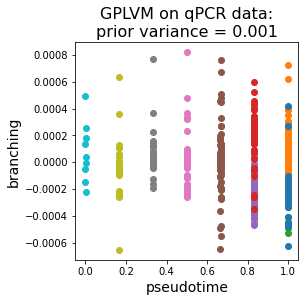

In [4]:


fig = plt.figure(figsize = plt.figaspect(1))
colors = plt.get_cmap("tab10").colors[::-1]
labels = df.index.unique()

for i, label in enumerate(labels):
    X_i = X[df.index == label]
    plt.scatter(X_i[:, 0], X_i[:, 1], c=[colors[i]], label=label)

#plt.legend()
plt.xlabel("pseudotime", fontsize=14)
plt.ylabel("branching", fontsize=14)
plt.title("GPLVM on qPCR data:" +"\n"+ "prior variance = %s" %(var), fontsize=16)
#plt.title('TSNE: perp = %d' %(perp)+', iter = %d' %(iter), fontsize=sizeTitle)
plt.show()